In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
!pip uninstall tensorflow tensorflow-text tensorflow_decision_forests keras tensorflowjs -y
!pip install tensorflow==2.15.0 tensorflow-text==2.15.0 tensorflow_decision_forests==1.8.1 keras==2.15.0 tensorflowjs==4.21.0 mediapipe

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp

# --- Configuration ---
PROJECT_ROOT = '/content/drive/MyDrive/BISARA'

# Define paths relative to the project root
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'raw')
SAVE_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed')

# Parameters for preprocessing
SEQUENCE_LENGTH = 30  
NUM_LANDMARKS = 21  

def extract_landmarks(video_path, hands_model):
    """Extracts hand landmarks for up to two hands from a single video file."""
    sequence = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the BGR image to RGB and process it with MediaPipe
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands_model.process(rgb_frame)

        # Create a placeholder for landmarks of two hands (21 landmarks * 3 coords * 2 hands)
        frame_landmarks = np.zeros(NUM_LANDMARKS * 3 * 2)

        if results.multi_hand_landmarks:
            # Loop through up to two detected hands
            for i, hand_landmarks in enumerate(results.multi_hand_landmarks[:2]):
                # Determine the starting index for this hand's data
                start_idx = i * (NUM_LANDMARKS * 3)

                # Extract and flatten landmarks (x, y, z)
                landmarks_x = [lm.x for lm in hand_landmarks.landmark]
                landmarks_y = [lm.y for lm in hand_landmarks.landmark]
                landmarks_z = [lm.z for lm in hand_landmarks.landmark]

                # Place the landmarks in the correct part of the array
                frame_landmarks[start_idx : start_idx + NUM_LANDMARKS] = landmarks_x
                frame_landmarks[start_idx + NUM_LANDMARKS : start_idx + 2 * NUM_LANDMARKS] = landmarks_y
                frame_landmarks[start_idx + 2 * NUM_LANDMARKS : start_idx + 3 * NUM_LANDMARKS] = landmarks_z

        sequence.append(frame_landmarks)

    cap.release()
    return np.array(sequence)

def preprocess_data():
    """
    Finds video files, processes them to extract hand landmarks, normalizes
    sequence length, and saves the data.
    """
    # Initialize MediaPipe Hands model
    mp_hands = mp.solutions.hands
    hands_model = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

    if not os.path.exists(SAVE_PATH):
        os.makedirs(SAVE_PATH)

    class_names = sorted([d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))])
    label_map = {name: i for i, name in enumerate(class_names)}
    print(f"Found classes: {label_map}")

    features = []
    labels = []

    for class_name in class_names:
        class_path = os.path.join(DATA_PATH, class_name)
        print(f"Processing videos in: {class_path}")

        for video_name in os.listdir(class_path):
            video_path = os.path.join(class_path, video_name)

            # Extract landmarks for the entire video
            landmark_sequence = extract_landmarks(video_path, hands_model)

            if landmark_sequence is None or landmark_sequence.shape[0] == 0:
                print(f"Warning: Could not extract landmarks from {video_path}, skipping.")
                continue

# --- Normalize Sequence Length to 30 Frames ---
            TARGET_SEQUENCE_LENGTH = 30
            current_length = len(landmark_sequence)
            
            FEATURE_SIZE = NUM_LANDMARKS * 3 * 2  # 21 landmarks * 3 coordinates (x, y, z) * 2 hands

            if current_length > TARGET_SEQUENCE_LENGTH:
                # If the sequence is too long, downsample it.
                indices = np.linspace(0, current_length - 1, TARGET_SEQUENCE_LENGTH, dtype=int)
                landmark_sequence = landmark_sequence[indices]

            elif current_length < TARGET_SEQUENCE_LENGTH:
                # If the sequence is too short, pad it with zeros.
                padding_needed = TARGET_SEQUENCE_LENGTH - current_length
                padding = np.zeros((padding_needed, FEATURE_SIZE)) # Update padding shape
                landmark_sequence = np.vstack((landmark_sequence, padding))

            # --- DATA AUGMENTATION ---
            # Add original landmarks
            features.append(landmark_sequence)
            labels.append(label_map[class_name])

            # Create and add flipped landmarks for two hands
            flipped_landmark_sequence = landmark_sequence.copy()
            # Flip Hand 1's x-coordinates (indices 0 to 20)
            flipped_landmark_sequence[:, :NUM_LANDMARKS] = 1 - flipped_landmark_sequence[:, :NUM_LANDMARKS]
            # Flip Hand 2's x-coordinates (indices 63 to 83)
            hand2_x_start = NUM_LANDMARKS * 3
            hand2_x_end = hand2_x_start + NUM_LANDMARKS
            flipped_landmark_sequence[:, hand2_x_start:hand2_x_end] = 1 - flipped_landmark_sequence[:, hand2_x_start:hand2_x_end]

            features.append(flipped_landmark_sequence)
            labels.append(label_map[class_name])

    hands_model.close()

    X = np.array(features)
    y = np.array(labels)

    print("\nSaving processed data...")
    np.save(os.path.join(SAVE_PATH, 'X_data_landmarks.npy'), X)
    np.save(os.path.join(SAVE_PATH, 'y_data_landmarks.npy'), y)
    np.save(os.path.join(SAVE_PATH, 'label_map.npy'), label_map)

    print(f"Preprocessing complete.")
    print(f"Features shape (X): {X.shape}")
    print(f"Labels shape (y): {y.shape}")
    print(f"Data saved to: {SAVE_PATH}")


if __name__ == '__main__':
    preprocess_data()

Found classes: {'Blank': 0, 'Halo': 1, 'Pagi': 2, 'Selamat': 3, 'Semua': 4}
Processing videos in: /content/drive/MyDrive/BISARA/data/raw/Blank
Processing videos in: /content/drive/MyDrive/BISARA/data/raw/Halo
Processing videos in: /content/drive/MyDrive/BISARA/data/raw/Pagi
Processing videos in: /content/drive/MyDrive/BISARA/data/raw/Selamat
Processing videos in: /content/drive/MyDrive/BISARA/data/raw/Semua

Saving processed data...
Preprocessing complete.
Features shape (X): (1000, 30, 126)
Labels shape (y): (1000,)
Data saved to: /content/drive/MyDrive/BISARA/data/processed


Loading data...
Splitting data into training and testing sets...
Training data shape: (800, 30, 126)
Testing data shape: (200, 30, 126)
Building the LSTM model...
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 30, 64)            48896     
                                                                 
 dropout_37 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_35 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 dense_37 (Dense)     

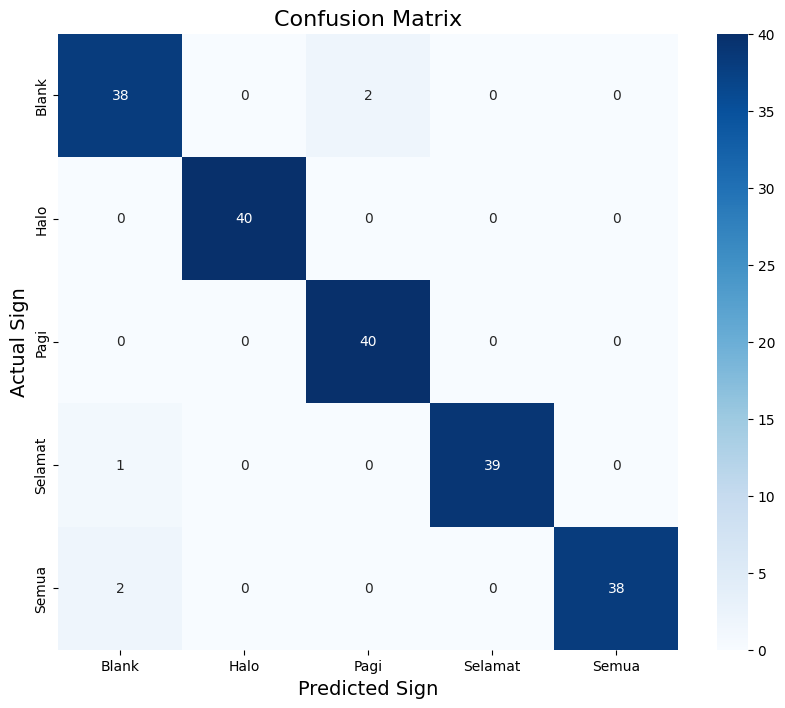


Saving TensorFlow.js model to: /content/drive/MyDrive/BISARA/model/model
TensorFlow.js model saved successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflowjs as tfjs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- Configuration ---
PROJECT_ROOT = '/content/drive/MyDrive/BISARA'
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed')
TFJS_MODEL_SAVE_PATH = os.path.join(PROJECT_ROOT, 'model', 'model')

def train_and_evaluate_model():
    """
    Loads data, builds, trains, evaluates, and saves an LSTM model.
    """
    # --- 1. Load the Data ---
    print("Loading data...")
    X = np.load(os.path.join(DATA_PATH, 'X_data_landmarks.npy'))
    y = np.load(os.path.join(DATA_PATH, 'y_data_landmarks.npy'))
    label_map = np.load(os.path.join(DATA_PATH, 'label_map.npy'), allow_pickle=True).item()

    # One-hot encode the labels
    num_classes = len(np.unique(y))
    y_categorical = to_categorical(y, num_classes=num_classes)

    # --- 2. Split Data ---
    print("Splitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_categorical, test_size=0.20, random_state=42, stratify=y
    )
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")

    # --- 3. Build the LSTM Model ---
    print("Building the LSTM model...")
    model = Sequential([
        Input(shape=X_train.shape[1:]),
        LSTM(64, return_sequences=True, activation='tanh'),
        Dropout(0.5),
        LSTM(128, return_sequences=False, activation='tanh'),
        Dropout(0.5),
        Dense(64, activation='tanh'),
        # Output layer with a node for each class
        Dense(num_classes, activation='softmax')
    ])

    # --- 4. Compile the Model ---
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # --- 5. Train the Model ---
    print("\nTraining the model...")
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

    # --- 6. Evaluate the Model ---
    print("\n--- Model Evaluation ---")
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification Report
    print("\nClassification Report:")
    class_names = sorted(label_map.keys(), key=lambda k: label_map[k])
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('Actual Sign', fontsize=14)
    plt.xlabel('Predicted Sign', fontsize=14)
    plt.show()


    # --- 7. Save the Trained Model ---
    print(f"\nSaving TensorFlow.js model to: {TFJS_MODEL_SAVE_PATH}")
    os.makedirs(TFJS_MODEL_SAVE_PATH, exist_ok=True)
    tfjs.converters.save_keras_model(model, TFJS_MODEL_SAVE_PATH)
    print("TensorFlow.js model saved successfully!")

# Run the entire process
if __name__ == '__main__':
    train_and_evaluate_model()